ORCHESTRATOR-WORKER :

In LangGraph and agentic AI, an orchestrator–worker workflow is a multi-agent pattern where:

The orchestrator agent decides what needs to be done
Worker agents actually perform specialized tasks.
LangGraph manages the routing, state passing, and agent transitions

Use orchestrator–worker workflow when:

A. Your system needs multiple specialized capabilities
Examples: search, coding, math, planning, RAG, scheduling.

B. Tasks require reasoning + execution separation
The orchestrator reasons; workers simply execute.

C. You want modularity and maintainability
Workers can be improved or replaced without touching other logic.

D. Tasks go through multiple steps or agents
If solving something requires:
analysis → code generation → data lookup → summarization
…this pattern is ideal.

E. You need reliability and reduced hallucinations
Workers stay narrow and factual; the orchestrator checks outputs.

F. You want to scale complexity gracefully
As your system grows, you just add more workers.



In [22]:
from langgraph.graph import START,END,StateGraph
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage,HumanMessage,SystemMessage,AnyMessage,BaseMessage
from typing_extensions import TypedDict,Annotated,Literal
from pydantic import BaseModel,Field
from IPython.display import Image,display
import operator

In [ ]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)

os.environ['GROQ_API_KEY']=os.getenv('GROQ_API_KEY')
os.environ['LANGSMITH_API_KEY']=os.getenv('LANGSMITH_API_KEY')
os.environ['LANGSMITH_PROJECT']='Agent_React'


In [24]:
# # Initialize chat model
from langchain_groq import ChatGroq

llm =ChatGroq(model="llama-3.1-8b-instant")

In [ ]:
#Schema for Structured output to use in planning 
class Section(BaseModel):
    name:str=Field(description="Name for this section of the report")
    description:str=Field(description="Brief overview of the main topics and concepts of the section")
    
#Using Sections Class (Wrapper)
class Sections(BaseModel):
    sections:list[Section]=Field(
        description="Sections of the report"
    )
#augument the llm with schema for structured output
planner =llm.with_structured_output(Sections)



why 2 class with section and sections above :

with section:Only one section is returned.
Your orchestrator cannot dynamically spawn multiple workers, because there is only a single section to process.
If you try to return multiple sections, it may fail schema validation, because the LLM is constrained to match the Section schema.

eg:{
  "name": "Introduction",
  "description": "This section introduces the topic of Agentic AI."
}


with sections: if we try to run multiple workers and multiple sections will be created 

{
  "sections": [
    {
      "name": "Introduction",
      "description": "This section introduces the topic of Agentic AI."
    },
    {
      "name": "Methodology",
      "description": "This section describes the steps used in the analysis."
    },
    {
      "name": "Results",
      "description": "This section presents findings and conclusions."
    }
  ]
}
The orchestrator now has a list of sections.
Each section can be sent to a dynamic worker (llm_call) using Send().
Enables parallel execution of multiple sections.

### Creating Workers Dynamically In Langgraph 
Because orchestrator-worker workflows are common, LangGraph has the Send API to support this. It lets you dynamically create worker nodes and send each one a specific input. Each worker has its own state, and all worker outputs are written to a shared state key that is accessible to the orchestrator graph. This gives the orchestrator access to all worker output and allows it to synthesize them into a final output. As you can see below, we iterate over a list of sections and Send each to a worker node. 

In [ ]:
from langgraph.constants import Send

class State(TypedDict):
    topic:str #report topic
    sections:list[Section] #list of report sections
    completed_sections:Annotated[list,operator.add] # merge function all workers write to this key in parellel
    final_report:str #final report

#worker state => Important
class Workerstate(TypedDict):
    section:Section
    completed_sections:Annotated[list,operator.add] 

# y completed_sections:Annotated[list,operator.add]?
# In our workflow:
# You have multiple worker nodes (llm_call) running in parallel, each generating one section of the report.
# All workers need to write to the same key in the state (completed_sections).
# Without a merge strategy, the last worker to finish would overwrite the others.

# operator.add is the merge function:

# Each worker returns a list of sections.
# LangGraph automatically does:
# state['completed_sections'] = state['completed_sections'] + worker_output['completed_sections']
# This ensures all workers’ outputs are appended together, not overwritten.

# Imagine 3 workers run in parallel:
# worker1 → {"completed_sections": ["Intro"]}
# worker2 → {"completed_sections": ["Methodology"]}
# worker3 → {"completed_sections": ["Results"]}

# LangGraph sees Annotated[list, operator.add] and merges automatically:

# global_state['completed_sections'] = ["Intro"] + ["Methodology"] + ["Results"]
# # Result:
# ["Intro", "Methodology", "Results"]
# No data is lost, order may be arbitrary if fully parallel.

C:\Users\Mohamed Arshad\AppData\Local\Temp\ipykernel_11592\2074134565.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [27]:
def orchestrator(state:State):
    """
    orchestrator that generates a plan for the report.
    """
    report_sections =planner.invoke(
        [
            SystemMessage(content="Generate a plan for the report."),
            HumanMessage(content=f"here is the report topic {state['topic']}")
        ]
    )
    print(report_sections)
    return {"sections":report_sections.sections}

In [28]:
def llm_call(state:Workerstate):
    """
    Worker writes a section of the report
    """
    #generate section
    section =llm.invoke(
        [SystemMessage(content="Write a report section following the provided name and description. Include no preamble for each section. Use markdown formatting"),

        HumanMessage(content=f"here is the Section name :{state['section'].name} and description:{state['section'].description}")

        ]
    )
    
    return {"completed_sections":[section.content]}

In [29]:
# conditional edge function to create llm_call workers that each write a section of the report
from langgraph.constants import Send
def assign_workers(state:State):
    """
    Assign a worker to each section in the plan
    """
    #writing in parallel via Send() API
    return [Send("llm_call",{"section":s})for s in state["sections"]]

C:\Users\Mohamed Arshad\AppData\Local\Temp\ipykernel_11592\2844666516.py:2: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


In [30]:
def synthesizer(state:State):
    """
    Synthesize full report from sections
    """
    # list of completed sections
    completed_sections = state['completed_sections']

    # Format completed section to str to use as context for final sections
    completed_report_sections = "\n\n---\n\n".join(completed_sections)
    return {"final_report":completed_report_sections}

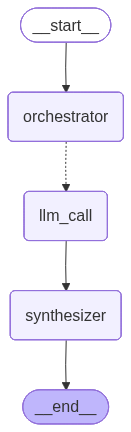

In [31]:
builder =StateGraph(State)

builder.add_node("orchestrator",orchestrator)
builder.add_node("llm_call",llm_call)
builder.add_node("synthesizer",synthesizer)

builder.add_edge(START,"orchestrator")
builder.add_conditional_edges("orchestrator",assign_workers,["llm_call"])
builder.add_edge("llm_call","synthesizer")
builder.add_edge("synthesizer",END)

graph =builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [34]:
state =graph.invoke({"topic":"create a report on ICE Automobile Engines"})

from IPython.display import Markdown
Markdown(state['final_report'])

sections=[Section(name='Introduction', description='Overview of ICE Automobile Engines, history, and significance'), Section(name='Types of ICE Engines', description='Discussion of different types of internal combustion engines used in automobiles'), Section(name='Key Components of ICE Engines', description='Explanation of engine blocks, cylinders, pistons, and other critical components'), Section(name='Operating Principles of ICE Engines', description='Explanation of how ICE engines generate power'), Section(name='Advantages and Disadvantages of ICE Engines', description='Discussion of benefits and drawbacks of ICE engines compared to other powertrains'), Section(name='Future of ICE Engines', description='Discussion of emerging trends and technologies in ICE engine development')]


**Introduction and Description**
=====================================

### Overview of ICE Automobile Engines

Internal Combustion Engine (ICE) automobile engines have been a cornerstone of the automotive industry for over a century. These engines have undergone significant transformations since their inception, with advancements in design, materials, and technology leading to improved efficiency, performance, and environmental sustainability.

### History of ICE Automobile Engines

The first ICE automobile engine was invented by Nikolaus August Otto in 1876, which laid the foundation for the development of modern internal combustion engines. Over the years, various types of ICE engines have been designed and manufactured, including:

* **Otto Cycle Engines**: The most common type of ICE engine, which operates on a four-stroke cycle of intake, compression, combustion, and exhaust.
* **Diesel Engines**: Developed by Rudolf Diesel in 1893, these engines operate on a compression ignition principle, which provides higher efficiency and torque.
* **Rotary Engines**: Designed by Felix Wankel in 1957, these engines use a rotating piston to generate power.

### Significance of ICE Automobile Engines

ICE automobile engines have played a pivotal role in shaping the modern transportation landscape. Their significance can be attributed to:

* **Widespread Adoption**: ICE engines have been widely adopted in the automotive industry due to their reliability, durability, and cost-effectiveness.
* **Performance and Efficiency**: Advances in ICE engine technology have led to significant improvements in performance, efficiency, and fuel economy.
* **Economic Impact**: The ICE engine industry has generated vast economic benefits, creating employment opportunities, stimulating innovation, and driving economic growth.

However, the increasing focus on environmental sustainability and energy efficiency has led to the development of alternative powertrains, such as hybrid and electric vehicles, which are expected to play a significant role in the future of the automotive industry.

---

**Types of ICE Engines**
==========================

### 1. Four-Stroke Engines

Four-stroke engines are the most common type of internal combustion engine used in automobiles. They operate on a four-stage cycle: intake, compression, power, and exhaust. The four-stroke engine is further divided into two categories: inline and V-type engines.

### 2. Two-Stroke Engines

Two-stroke engines are simpler and more compact than four-stroke engines. They complete a power cycle in two strokes of the piston, eliminating the need for valves. However, two-stroke engines produce more emissions and require a separate lubrication system.

### 3. Rotary Engines

Rotary engines, also known as Wankel engines, use a rotor instead of a piston to generate power. They are compact, lightweight, and produce a unique sound. However, rotary engines are prone to oil consumption and have lower fuel efficiency compared to traditional engines.

### 4. Diesel Engines

Diesel engines use compression ignition to generate power, rather than spark ignition. They are known for their fuel efficiency and durability, but also produce more noise and vibrations compared to gasoline engines.

### 5. Hybrid Engines

Hybrid engines combine the benefits of internal combustion engines and electric motors to improve fuel efficiency and reduce emissions. They use electric motors to assist the engine during acceleration and braking, reducing the load on the engine and improving overall performance.

### 6. Wankel-Hybrid Engines

Wankel-hybrid engines combine the benefits of rotary engines and electric motors. They use an electric motor to assist the rotor during acceleration and braking, reducing the load on the engine and improving overall performance.

### 7. Homogeneous Charge Compression Ignition (HCCI) Engines

HCCI engines use a combination of compression ignition and homogeneous charge to generate power. They are known for their high fuel efficiency and low emissions, but also require precise control over the fuel injection and ignition timing.

### 8. Free-Piston Engines

Free-piston engines use a piston that is not connected to a crankshaft, allowing for a more flexible and efficient design. They are known for their high power-to-weight ratio and low emissions, but also require advanced control systems to manage the piston motion.

---

### Key Components of ICE Engines

#### Engine Blocks

Engine blocks are the main structural component of an internal combustion engine (ICE). They house the cylinders where the fuel is burned to produce power. The block consists of:

* **Cylinder head**: Where the valves are located, allowing air and fuel into the cylinder and exhaust gases out of the cylinder.
* **Cylinder liners**: Metal liners that line the cylinders, protecting the block from the high-temperature combustion process.
* **Main bearings**: Support the crankshaft, allowing it to rotate freely.
* **Crankshaft**: Converts the up-and-down motion of the pistons into rotational energy.

#### Cylinders

Cylinders are where the fuel is burned to produce power. They are typically:

* **Inline**: Arranged in a straight line, often found in small engines.
* **V-type**: Arranged in a V-shape, often found in larger engines.
* **Flat**: Arranged horizontally, often found in two-stroke engines.

#### Pistons

Pistons are the moving components that transfer the force of the explosive combustion process to the crankshaft. They consist of:

* **Piston rings**: Seal the gap between the piston and cylinder, preventing oil leakage and ensuring proper combustion.
* **Piston pins**: Connect the piston to the connecting rod.
* **Connecting rod**: Transfers the force of the piston to the crankshaft.

#### Valves

Valves control the flow of air and fuel into the cylinder and exhaust gases out of the cylinder. They are typically:

* **Intake valves**: Allow air and fuel into the cylinder.
* **Exhaust valves**: Allow exhaust gases out of the cylinder.
* **Valve springs**: Return the valves to their closed position.

#### Other Critical Components

Other key components of ICE engines include:

* **Camshaft**: Operates the valves, opening and closing them at the correct time.
* **Timing belt or chain**: Synchronizes the rotation of the crankshaft and camshaft.
* **Fuel system**: Delivers fuel to the cylinders.
* **Ignition system**: Generates the spark or heat needed to ignite the fuel-air mixture.
* **Exhaust system**: Removes exhaust gases from the engine.

---

### Operating Principles of ICE Engines

#### Explanation of how ICE engines generate power

ICE (Internal Combustion Engine) engines generate power through a four-stroke process: Intake, Compression, Power, and Exhaust. This process is achieved through the coordinated movement of pistons, valves, and crankshafts.

#### Key Components Involved

* **Pistons**: Move up and down inside the cylinder, driven by the explosive force of the fuel combustion.
* **Cylinders**: The chambers where the air-fuel mixture is ignited, producing power.
* **Crankshaft**: Converts the up-and-down motion of the pistons into rotary motion, which is then transferred to the transmission and ultimately the wheels.
* **Valves**: Control the flow of air and fuel into the cylinder and the exhaust gases out of the cylinder.

#### The Four Strokes of the ICE Engine

1. **Intake Stroke**: The piston moves downward, creating a vacuum in the cylinder. Air and fuel are drawn into the cylinder through the intake valves.
2. **Compression Stroke**: The intake valves close, and the piston moves upward, compressing the air-fuel mixture in the cylinder.
3. **Power Stroke**: The spark plug ignites the compressed air-fuel mixture, causing a small explosion that pushes the piston downward. This motion is transferred to the crankshaft, generating power.
4. **Exhaust Stroke**: The piston moves upward again, pushing the exhaust gases out of the cylinder through the exhaust valves.

#### Power Generation

The power generated by the ICE engine is a result of the force exerted by the explosive combustion of the air-fuel mixture. As the piston moves downward, it rotates the crankshaft, which is connected to the transmission. The transmission then transmits the power to the wheels, propelling the vehicle forward.

#### Efficiency and Performance

The efficiency and performance of an ICE engine are influenced by various factors, including the design of the engine, the quality of the air-fuel mixture, and the timing of the ignition spark. Modern engines often employ advanced technologies, such as variable valve timing and turbocharging, to improve efficiency and performance.

#### Conclusion

In conclusion, ICE engines generate power through a complex process involving the coordinated movement of pistons, valves, and crankshafts. Understanding the operating principles of ICE engines is essential for designing and optimizing engines for improved efficiency and performance.

---

**Advantages and Disadvantages of ICE Engines**
=====================================================

### Advantages

* **Wide availability of fuel**: ICE engines can run on a variety of fuels, including gasoline, diesel, and biofuels, making them widely available and accessible.
* **Proven technology**: ICE engines have been in use for over a century, and the technology is well-established and proven.
* **High power-to-weight ratio**: ICE engines can produce a high amount of power relative to their weight, making them suitable for high-performance applications.
* **Lower upfront cost**: ICE engines are generally less expensive to purchase and install than alternative powertrains.
* **Easy maintenance and repair**: ICE engines are relatively simple and easy to maintain and repair, with many parts being interchangeable.

### Disadvantages

* **Low efficiency**: ICE engines have a relatively low thermal efficiency, converting only about 20-30% of the energy released from the fuel into usable power.
* **Emissions**: ICE engines emit a range of pollutants, including carbon dioxide, nitrogen oxides, and particulate matter, contributing to air pollution and climate change.
* **Noise pollution**: ICE engines are a significant source of noise pollution, particularly in urban areas.
* **Fuel consumption**: ICE engines consume a significant amount of fuel, particularly in heavy-duty applications.
* **Limited lifespan**: ICE engines have a limited lifespan and require regular replacement, contributing to waste and emissions.

---

### Future of ICE Engines

#### Introduction

The Internal Combustion Engine (ICE) has been the backbone of the automotive industry for over a century, providing a reliable and efficient means of propulsion for vehicles. However, with increasing concerns over environmental sustainability and stricter emissions regulations, the industry is shifting towards cleaner and more efficient technologies. This section discusses the emerging trends and technologies in ICE engine development, exploring the potential future of these engines and their role in the evolving automotive landscape.

#### Advancements in Materials and Design

One of the key areas of focus in ICE engine development is the use of advanced materials and design techniques to improve efficiency and reduce emissions. This includes the use of lightweight materials such as aluminum and carbon fiber, which can help to reduce the weight of the engine and improve fuel efficiency. Additionally, designers are exploring new geometries and internal combustion chamber designs to optimize combustion and reduce emissions.

#### Hybridization and Downsizing

Hybridization and downsizing are two emerging trends in ICE engine development. By combining a traditional ICE with an electric motor, hybrid engines can achieve significant fuel efficiency gains and reduced emissions. Downsizing, on the other hand, involves reducing the size of the engine while maintaining its power output, which can also lead to improved fuel efficiency and reduced emissions.

#### Alternative Fuels and Power Sources

As concerns over emissions and climate change continue to grow, the industry is exploring alternative fuels and power sources for ICE engines. This includes the use of biofuels, which can be derived from renewable sources such as plants and waste materials. Additionally, some manufacturers are exploring the use of hydrogen fuel cells, which can provide zero-emission propulsion for vehicles.

#### Future Outlook

While the future of ICE engines may seem uncertain in the face of emerging technologies such as electric vehicles and hydrogen fuel cells, these engines are likely to remain a key part of the automotive landscape for the foreseeable future. As regulations continue to evolve and consumer preferences shift, the industry will need to adapt and innovate to meet changing demands. By embracing emerging trends and technologies, ICE engine manufacturers can help to ensure a sustainable and efficient future for transportation.

#### Conclusion

The future of ICE engines is likely to be shaped by emerging trends and technologies that prioritize efficiency, sustainability, and reduced emissions. By exploring new materials and design techniques, hybridizing and downsizing engines, and embracing alternative fuels and power sources, manufacturers can help to ensure a long and sustainable future for these engines. As the industry continues to evolve, one thing is clear: the ICE engine will remain a vital part of the automotive landscape for years to come.